In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Define the directories for the dataset
train_dir = 'Face Mask Dataset/Train'
valid_dir = 'Face Mask Dataset/Test'
test_dir = 'Face Mask Dataset/Validation'

In [4]:
# Define the image size for training and validation
target_size = (128, 128)

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

Found 10000 images belonging to 2 classes.


In [5]:
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)


Found 992 images belonging to 2 classes.


In [6]:
# Create a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)                3

In [10]:
# Define the checkpoint to save the model weights during training
checkpoint = ModelCheckpoint('model_{epoch:02d}_checkpoint.h5', save_best_only=True, save_weights_only=True)

In [11]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[checkpoint]
)

Epoch 1/5
313/313 [==============================] - 107s 340ms/step - loss: 0.1307 - accuracy: 0.9511 - val_loss: 0.0624 - val_accuracy: 0.9738
Epoch 2/5
313/313 [==============================] - 48s 153ms/step - loss: 0.0387 - accuracy: 0.9864 - val_loss: 0.0477 - val_accuracy: 0.9839
Epoch 3/5
313/313 [==============================] - 48s 153ms/step - loss: 0.0275 - accuracy: 0.9898 - val_loss: 0.0472 - val_accuracy: 0.9788
Epoch 4/5
313/313 [==============================] - 48s 154ms/step - loss: 0.0226 - accuracy: 0.9914 - val_loss: 0.0433 - val_accuracy: 0.9859
Epoch 5/5
313/313 [==============================] - 48s 154ms/step - loss: 0.0228 - accuracy: 0.9913 - val_loss: 0.0545 - val_accuracy: 0.9829


In [22]:
# Load the VGG19 model
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Create a new model using the VGG19 base
model_vgg19 = Sequential()
model_vgg19.add(vgg19_model)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(64, activation='relu'))
model_vgg19.add(Dense(1, activation='sigmoid'))

In [23]:
# Compile the VGG19 model
model_vgg19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the checkpoint to save the model weights during training
vgg19_checkpoint = ModelCheckpoint('vgg19_{epoch:02d}_checkpoint.h5', save_best_only=True, save_weights_only=True)


In [24]:
# Train the VGG19 model
model_vgg19.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[vgg19_checkpoint]
)

Epoch 1/5
313/313 [==============================] - 184s 586ms/step - loss: 0.0655 - accuracy: 0.9743 - val_loss: 0.0284 - val_accuracy: 0.9879
Epoch 2/5
313/313 [==============================] - 183s 585ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.0605 - val_accuracy: 0.9819
Epoch 3/5
313/313 [==============================] - 182s 583ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0215 - val_accuracy: 0.9919
Epoch 4/5
313/313 [==============================] - 183s 585ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 0.0599 - val_accuracy: 0.9808
Epoch 5/5
313/313 [==============================] - 183s 585ms/step - loss: 0.0135 - accuracy: 0.9953 - val_loss: 0.0213 - val_accuracy: 0.9919


In [ ]:
import os
# Load the trained model
# Get the current directory
current_dir = os.getcwd()

# Find the latest checkpoint file
latest_checkpoint = max([file for file in os.listdir(current_dir) if file.startswith('vgg19_')], key=os.path.getctime)

model_vgg19.load_weights(latest_checkpoint)


In [25]:
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Ensure that the order is preserved for evaluation
)

Found 800 images belonging to 2 classes.


In [26]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

25/25 [==============================] - 5s 226ms/step - loss: 0.0291 - accuracy: 0.9912
Test Loss: 0.029055887833237648
Test Accuracy: 0.9912499785423279


In [27]:
# Evaluate the model on the test dataset
vgg19_loss, vgg19_accuracy = model_vgg19.evaluate(test_generator, steps=len(test_generator))
print('VGG19 Test Loss:', vgg19_loss)
print('VGG19 Test Accuracy:', vgg19_accuracy)

25/25 [==============================] - 13s 533ms/step - loss: 0.0015 - accuracy: 1.0000
VGG19 Test Loss: 0.0015493810642510653
VGG19 Test Accuracy: 1.0


1/1 [==============================] - 0s 41ms/step
Probability of wearing a mask: 0.9999934


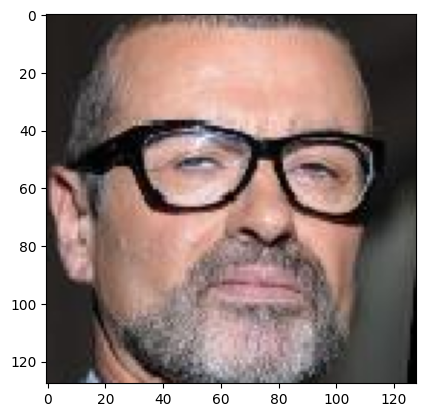

In [36]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess a single test image
image_path = 'Face Mask Dataset/Test/WithoutMask/51.png'
image = load_img(image_path, target_size=target_size)
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array /= 255.0
import matplotlib.pyplot as plt
plt.imshow(image)

# Make predictions on the image
prediction = model_vgg19.predict(image_array)
probability = prediction[0][0]

# Print the predicted probability
print('Probability of not wearing a mask:', probability)


In [34]:
prediction

array([[0.00236484]], dtype=float32)

In [37]:
len(test_generator)

25